# Lab 10 - Convolutional Neural Network, CNN

Dominik Gaweł

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dg7s/Machine-Learning/blob/main/hw/Adversarial_Examples_Fooling_LeNet_5.ipynb)
-------------------------------

# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

In [6]:
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from matplotlib import pyplot
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 336kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.44MB/s]


## Task 1 – CNN Dreams: Last Homework Assignment Revisited


In [7]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # input: 1×28×28
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.sig1  = nn.Sigmoid()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.sig2  = nn.Sigmoid()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1   = nn.Linear(16*5*5, 120)
        self.sig3  = nn.Sigmoid()
        self.fc2   = nn.Linear(120, 84)
        self.sig4  = nn.Sigmoid()
        self.fc3   = nn.Linear(84, 10)
        # final logits (no activation)

    def forward(self, x):
        x = self.sig1(self.conv1(x))
        x = self.pool1(x)
        x = self.sig2(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*5*5)
        x = self.sig3(self.fc1(x))
        x = self.sig4(self.fc2(x))
        return self.fc3(x)

In [8]:
net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)
net.train()
for epoch in range(16):

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)

        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean")
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()
        optimizer.step()
net.eval()

epoch: 0 batch: 0 current batch loss: 2.355853796005249
epoch: 0 batch: 1 current batch loss: 2.3327057361602783
epoch: 0 batch: 2 current batch loss: 2.3135781288146973
epoch: 0 batch: 3 current batch loss: 2.315762519836426
epoch: 0 batch: 4 current batch loss: 2.305966377258301
epoch: 0 batch: 5 current batch loss: 2.300494432449341
epoch: 0 batch: 6 current batch loss: 2.3010663986206055
epoch: 0 batch: 7 current batch loss: 2.307525157928467
epoch: 0 batch: 8 current batch loss: 2.303219795227051
epoch: 0 batch: 9 current batch loss: 2.305927276611328
epoch: 0 batch: 10 current batch loss: 2.3071155548095703
epoch: 0 batch: 11 current batch loss: 2.30230450630188
epoch: 0 batch: 12 current batch loss: 2.3071980476379395
epoch: 0 batch: 13 current batch loss: 2.3009912967681885
epoch: 0 batch: 14 current batch loss: 2.3086678981781006
epoch: 0 batch: 15 current batch loss: 2.305269718170166
epoch: 0 batch: 16 current batch loss: 2.3043642044067383
epoch: 0 batch: 17 current batch l

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (sig1): Sigmoid()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (sig2): Sigmoid()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (sig3): Sigmoid()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (sig4): Sigmoid()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
initial_dream = torch.randn(10, 1, 28, 28, device=device)

def dream_with_l2_animated(initial_dream, lambda_l2, steps=200):
    dream = initial_dream.clone().detach().requires_grad_(True)
    net.eval()
    targets = torch.arange(10, device=device)

    optimizer = torch.optim.Adam([dream], lr=0.1)
    frames = []
    confidence_history = []

    for step in range(steps):
        optimizer.zero_grad()
        logits = net(dream)
        ce_loss = F.cross_entropy(logits, targets)
        l2_loss = lambda_l2 * dream.pow(2).mean()
        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()
        dream.data.clamp_(-1, +1)

        if step % 10 == 0 or step == steps-1:
            with torch.no_grad():
                denorm = dream.detach().cpu() * 0.3081 + 0.1307
                denorm = denorm.clamp(0, 1).numpy()
                probs = F.softmax(net(dream), dim=1)
                confidences = probs[range(10), targets].detach().cpu().numpy()

            frames.append(denorm)
            confidence_history.append(confidences)

    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle(f"λ = {lambda_l2}", fontsize=14, y=0.95)
    plt.subplots_adjust(top=0.85, hspace=0.3, wspace=0.3)
    plt.close()

    ims = []
    for i, ax in enumerate(axes.flatten()):
        im = ax.imshow(frames[0][i,0], cmap='gray', animated=True)
        ax.axis('off')
        ax.set_title(f"{i}\n", fontsize=10)
        ims.append(im)

    def update(frame):
        for i, im in enumerate(ims):
            im.set_array(frames[frame][i,0])
            axes.flatten()[i].set_title(f"{i}\n{confidence_history[frame][i]:.1%}", fontsize=10)
        return ims

    return FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True)

lambdas = [0.01, 0.1, 1.0, 10.0]

for l in lambdas:
    ani = dream_with_l2_animated(initial_dream, l)
    display(HTML(ani.to_html5_video()))
    plt.close()

Even without an $L_2$ penalty, the CNN “dreams” produce blob and stroke like patterns rather than pure noise, and increasing the L₂ weight causes them to sharpen into faint but coherent digit shapes that strongly resemble real MNIST characters. This happens because the CNN’s convolutional filters and pooling layers enforce local edge detection and hierarchical feature assembly, guiding gradient updates to produce continuous loops and lines in the correct spatial arrangements.

## Task 2 – Adversarial Examples: Fooling LeNet-5


λ = 0.01: success counts per digit = {0: 1, 1: 8, 2: 3, 3: 3, 4: 5, 5: 5, 6: 4, 7: 3, 8: 3, 9: 7}


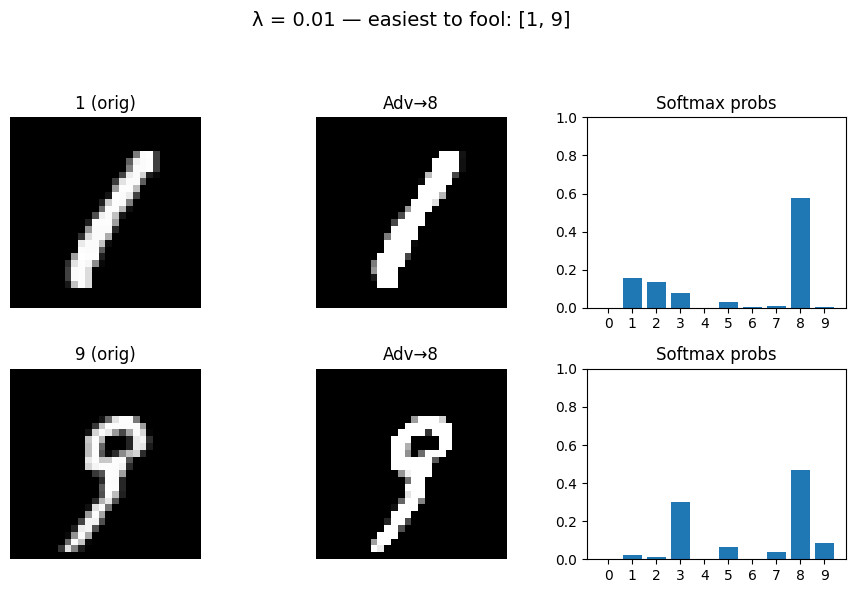

λ = 0.1: success counts per digit = {0: 1, 1: 8, 2: 3, 3: 3, 4: 5, 5: 5, 6: 4, 7: 3, 8: 3, 9: 7}


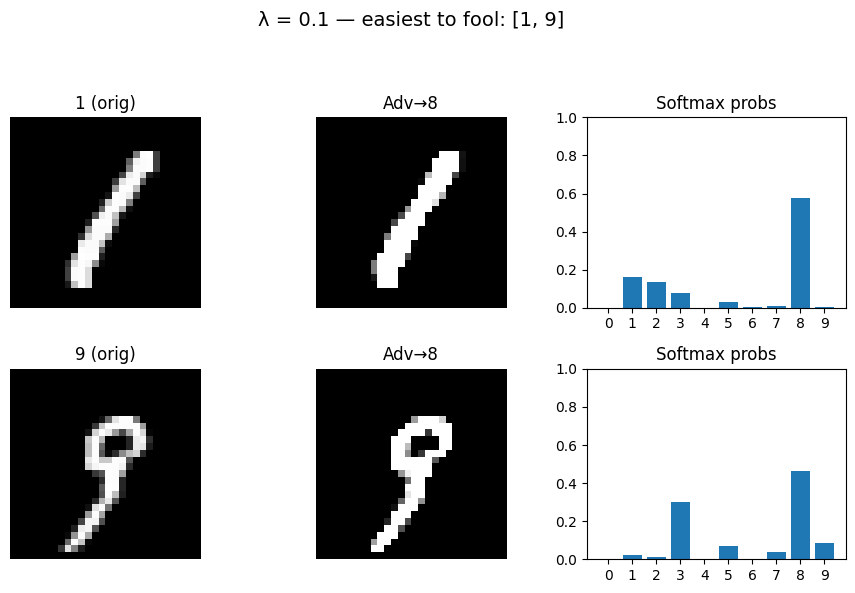

λ = 1: success counts per digit = {0: 1, 1: 8, 2: 3, 3: 3, 4: 5, 5: 5, 6: 4, 7: 3, 8: 3, 9: 7}


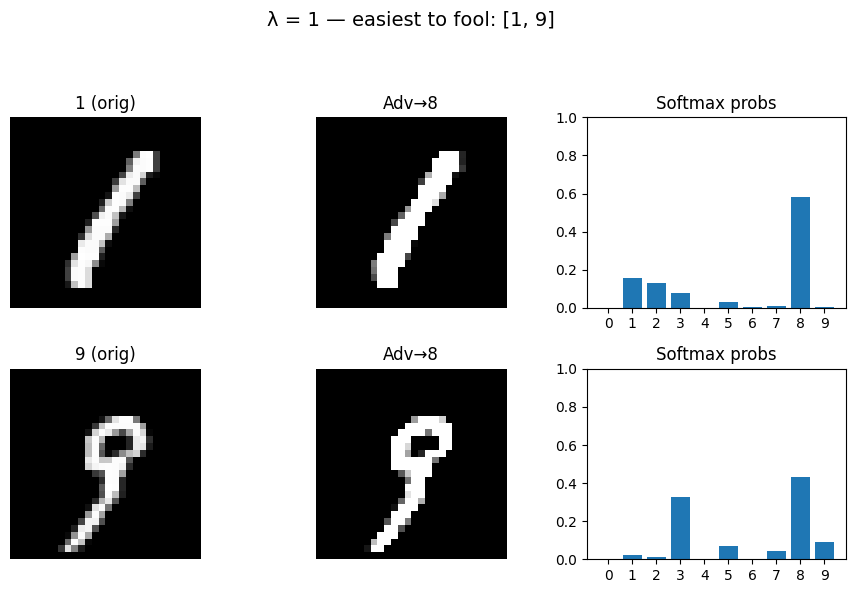

λ = 10.0: success counts per digit = {0: 1, 1: 8, 2: 3, 3: 3, 4: 5, 5: 5, 6: 4, 7: 3, 8: 3, 9: 7}


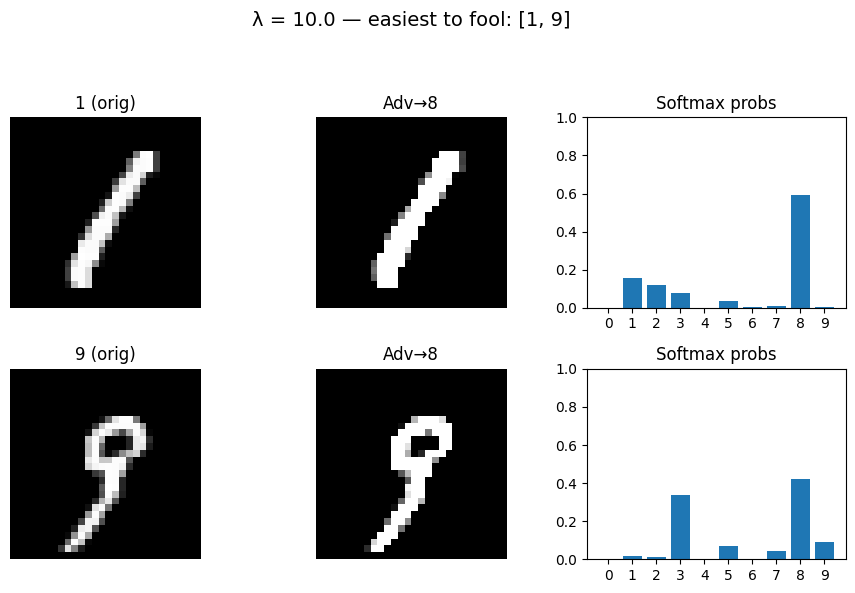

In [28]:
class_samples = {i: [] for i in range(10)}
for x, y in trainset:
    if len(class_samples[y]) < 9:
        class_samples[y].append((x, y))
    if all(len(v)==9 for v in class_samples.values()):
        break

def generate_adv_example(x, y_target, model,
                         lambda_l2=0.01, max_steps=500, eps=0.3):
    """
    x:       [1,1,28,28] original image tensor
    y_target:[1]        desired wrong label
    returns: adv_x, delta, pred_label, steps_used
    """
    x   = x.to(device)
    y_t = y_target.to(device)
    delta = torch.zeros_like(x, device=device, requires_grad=True)
    opt   = torch.optim.Adam([delta], lr=0.05)

    for step in range(1, max_steps+1):
        opt.zero_grad()
        logits = model(x + delta)
        loss   = F.cross_entropy(logits, y_t) + lambda_l2 * delta.pow(2).mean()
        loss.backward()
        opt.step()
        delta.data.clamp_(-eps, eps)

        pred = logits.argmax(dim=1)

    adv_x = (x + delta).detach().cpu().clamp(0,1)
    return adv_x, delta.detach().cpu(), pred.item(), step

lambdas = [0.01, 0.1, 1, 10.0]
summary = {}

for lam in lambdas:
    successes = {d: 0 for d in range(10)}
    examples = {d: None for d in range(10)}

    for digit in range(10):
        for i, (x, _) in enumerate(class_samples[digit]):
            target = torch.tensor([(digit + i + 1) % 10], dtype=torch.long)
            adv_x, delta, pred, steps = generate_adv_example(
                x.unsqueeze(0), target, net,
                lambda_l2=lam, max_steps=500, eps=0.3
            )
            if pred == target.item():
                successes[digit] += 1
                if examples[digit] is None:
                    examples[digit] = {
                        'orig': x,
                        'adv': adv_x.squeeze(0),
                        'logits': net(adv_x.to(device)).detach().cpu().squeeze()
                    }
    total = sum(successes.values())  # maks. 90
    summary[lam] = total

    sorted_digits = sorted(successes, key=lambda d: -successes[d])
    easiest2 = sorted_digits[:2]

    print(f"λ = {lam}: success counts per digit = {successes}")

    fig, axes = plt.subplots(2, 3, figsize=(9, 6))
    fig.suptitle(f"λ = {lam} — easiest to fool: {easiest2}", fontsize=14)

    for row, d in enumerate(easiest2):
        ex = examples[d]
        # original
        ax0 = axes[row, 0]
        ax0.imshow(ex['orig'].squeeze(), cmap='gray')
        ax0.set_title(f"{d} (orig)")
        ax0.axis('off')

        # adversarial
        ax1 = axes[row, 1]
        ax1.imshow(ex['adv'].squeeze(), cmap='gray')
        ax1.set_title(f"Adv→{ex['logits'].argmax():d}")
        ax1.axis('off')

        # softmax distribution
        ax2 = axes[row, 2]
        probs = F.softmax(ex['logits'], dim=0).numpy()
        ax2.bar(range(10), probs)
        ax2.set_xticks(range(10))
        ax2.set_ylim(0,1)
        ax2.set_title("Softmax probs")

    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

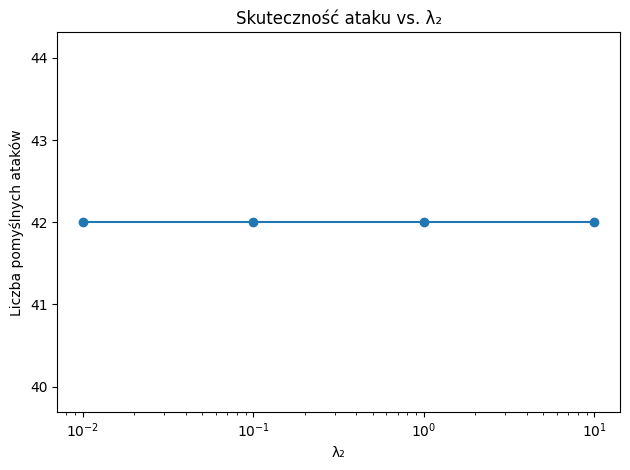

In [31]:
plt.plot(list(summary.keys()), list(summary.values()), marker='o')
plt.xscale('log')
plt.xlabel('λ₂')
plt.ylabel('Liczba pomyślnych ataków')
plt.title('Skuteczność ataku vs. λ₂')
plt.tight_layout()
plt.show()

**Success rate**: Across all four $\lambda_{l2}$ values $(0.01, 0.1, 1.0, 10.0)$, we fooled LeNet-5 $42$ times out of $90$ attempts ($~47 %$).

**Effect of $\lambda_{l2}$**: Changing $\lambda_{l2}$ in that range didn’t affect either the number of successful attacks or the softmax distributions—perturbations stayed the same size (likely limited by your ±0.3 clamp), so the penalty never kicked in.

All other $\lambda$ values produced the same near-identical images and confidence plots.